<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Roots of 1D equations </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.34</h2>
</center>

<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [Bisection Method](#bisection)
* [Fixed Point Iteration and Cobweb diagram](#fpi)
* [FPI - example from etxtbook](#fpi-textbook-example)
* [Newton Method](#nm)
* [Wilkinson Polynomial](#wilkinson)
* [Acknowledgements](#acknowledgements)
* [Extra Examples](#extraexamples)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
%matplotlib inline
from ipywidgets import interact
from ipywidgets import widgets
sym.init_printing()
from scipy import optimize

<div id='intro' />

# Introduction
[Back to TOC](#toc)

Hello again! In this document we're going to learn how to find a 1D equation's solution using numerical methods. First, let's start with the definition of a root:

<b>Definition</b>: The function $f(x)$ has a <b>root</b> in $x = r$ if $f(r) = 0$.

An example: Let's say we want to solve the equation $x + \log(x) = 3$. We can rearrange the equation: $x + \log(x) - 3 = 0$. That way, to find its solution we can find the root of $f(x) = x + \log(x) - 3$. Now let's study some numerical methods to solve these kinds of problems. 

Defining a function $f(x)$

In [2]:
f = lambda x: x+np.log(x)-3

Finding $r$ using sympy

In [3]:
y = sym.Symbol('y')
fsym = lambda y: y+sym.log(y)-3
r_all=sym.solve(sym.Eq(fsym(y), 0), y)
r=r_all[0].evalf()
print(r)
print(r_all)

2.20794003156932
[LambertW(exp(3))]


In [4]:
def find_root_manually(r=2.0): 
    x = np.linspace(1,3,1000)
    plt.figure(figsize=(8,8))
    plt.plot(x,f(x),'b-')
    plt.grid()
    plt.ylabel('$f(x)$',fontsize=16)
    plt.xlabel('$x$',fontsize=16)
    plt.title('What is r such that $f(r)='+str(f(r))+'$? $r='+str(r)+'$',fontsize=16)
    plt.plot(r,f(r),'k.',markersize=20)
    plt.show()
interact(find_root_manually,r=(1e-5,3,1e-3))

interactive(children=(FloatSlider(value=2.0, description='r', max=3.0, min=1e-05, step=0.001), Output()), _dom…

<function __main__.find_root_manually(r=2.0)>

<div id='bisection' />

# Bisection Method
[Back to TOC](#toc)

The bisection method finds the root of a function $f$, where $f$ is a **continuous** function.
If we want to know if this has a root, we have to check if there is an interval $[a,b]$ for which 
$f(a)\cdot f(b) < 0$. When these 2 conditions are satisfied, it means that there is a value $r$, between $a$ and $b$, for which $f(r) = 0$. To summarize how this method works, start with the aforementioned interval (checking that there's a root in it), and split it into two smaller intervals $[a,c]$ and $[c,b]$. Then, check which of the two intervals contains a root. Keep splitting each "eligible" interval until the algorithm converges or the tolerance is surpassed.

In [5]:
def bisect(f, a, b, tol=1e-5, maxNumberIterations=100):
    fa = f(a)
    fb = f(b)
    i = 0
    # Just checking if the sign is not negative => not root  necessarily 
    if np.sign(f(a)*f(b)) >= 0:
        print('f(a)f(b)<0 not satisfied!')
        return None
  
    #Printing the evolution of the computation of the root
    print(' i |     a     |     c     |     b     |     fa    |     fc     |     fb     |   b-a')
    print('----------------------------------------------------------------------------------------')
    
    while ((b-a)/2 > tol) and i<=maxNumberIterations:
        c = (a+b)/2.
        fc = f(c)
        print('%2d | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f' %
              (i+1, a, c, b, fa, fc, fb, b-a))
        # Did we find the root?
        if fc == 0:
            print('f(c)==0')
            break
        elif np.sign(fa*fc) < 0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
        i += 1
        
    xc = (a+b)/2.
    return xc

In [6]:
# Initial example
f1 = lambda x: x+np.log(x)-3
# A different function, notice that x is multiplied to teh exponential now and not added, as before.
f2 = lambda x: x*np.exp(x)-3
# This is the introductory example about Fixed Point Iteration
f3 = lambda x: np.cos(x)-x
bisect(f1,0.5,3)

 i |     a     |     c     |     b     |     fa    |     fc     |     fb     |   b-a
----------------------------------------------------------------------------------------
 1 | 0.5000000 | 1.7500000 | 3.0000000 | -3.1931472 | -0.6903842 | 1.0986123 | 2.5000000
 2 | 1.7500000 | 2.3750000 | 3.0000000 | -0.6903842 | 0.2399974 | 1.0986123 | 1.2500000
 3 | 1.7500000 | 2.0625000 | 2.3750000 | -0.6903842 | -0.2135812 | 0.2399974 | 0.6250000
 4 | 2.0625000 | 2.2187500 | 2.3750000 | -0.2135812 | 0.0156940 | 0.2399974 | 0.3125000
 5 | 2.0625000 | 2.1406250 | 2.2187500 | -0.2135812 | -0.0982772 | 0.0156940 | 0.1562500
 6 | 2.1406250 | 2.1796875 | 2.2187500 | -0.0982772 | -0.0411310 | 0.0156940 | 0.0781250
 7 | 2.1796875 | 2.1992188 | 2.2187500 | -0.0411310 | -0.0126791 | 0.0156940 | 0.0390625
 8 | 2.1992188 | 2.2089844 | 2.2187500 | -0.0126791 | 0.0015172 | 0.0156940 | 0.0195312
 9 | 2.1992188 | 2.2041016 | 2.2089844 | -0.0126791 | -0.0055785 | 0.0015172 | 0.0097656
10 | 2.2041016 | 2.2065430 |

In [7]:
# Initial example
f1 = lambda x: x+np.log(x)-3
# A different function, notice that x is multiplied to teh exponential now and not added, as before.
f2 = lambda x: x*np.exp(x)-3
# This is the introductory example about Fixed Point Iteration
f3 = lambda x: np.cos(x)-x
bisect(f2,0.5,3,tol=1e-5)

 i |     a     |     c     |     b     |     fa    |     fc     |     fb     |   b-a
----------------------------------------------------------------------------------------
 1 | 0.5000000 | 1.7500000 | 3.0000000 | -2.1756394 | 7.0705547 | 57.2566108 | 2.5000000
 2 | 0.5000000 | 1.1250000 | 1.7500000 | -2.1756394 | 0.4652440 | 7.0705547 | 1.2500000
 3 | 0.5000000 | 0.8125000 | 1.1250000 | -2.1756394 | -1.1690030 | 0.4652440 | 0.6250000
 4 | 0.8125000 | 0.9687500 | 1.1250000 | -1.1690030 | -0.4476837 | 0.4652440 | 0.3125000
 5 | 0.9687500 | 1.0468750 | 1.1250000 | -0.4476837 | -0.0177307 | 0.4652440 | 0.1562500
 6 | 1.0468750 | 1.0859375 | 1.1250000 | -0.0177307 | 0.2167810 | 0.4652440 | 0.0781250
 7 | 1.0468750 | 1.0664062 | 1.0859375 | -0.0177307 | 0.0978261 | 0.2167810 | 0.0390625
 8 | 1.0468750 | 1.0566406 | 1.0664062 | -0.0177307 | 0.0396284 | 0.0978261 | 0.0195312
 9 | 1.0468750 | 1.0517578 | 1.0566406 | -0.0177307 | 0.0108447 | 0.0396284 | 0.0097656
10 | 1.0468750 | 1.0493164 | 1

It's very important to define a concept called **convergence rate**. 
This rate shows how fast the convergence of a method is at a specified point.

The convergence rate for the bisection is always 0.5 because this method uses the half of the interval for each iteration.

<div id='fpi' />

# Fixed Point Iteration and Cobweb diagram
[Back to TOC](#toc)

To learn about the Fixed-Point Iteration we will first learn about the concept of Fixed Point.

A Fixed Point of a function $g$ is a real number $r$, where $g(r) = r$

The Fixed-Point Iteration is based in the Fixed Point concept and works like this to find the root of a function:

\begin{align*} 
    x_{0} &= initial\_guess \\ 
    x_{i+1} &= g(x_{i})
\end{align*}

To find an equation's solution using this method you'll have to move around some things to rearrange the equation in the form $x = g(x)$. That way, you'll be iterating over the funcion $g(x)$, but you will **not** find $g$'s root, but $f(x) = g(x) - x$ (or $f(x) = x - g(x)$)'s root. In our following example, we'll find the solution to $f(x) = x - \cos(x)$ by iterating over the funcion $g(x) = \cos(x)$.



In [8]:
def cobweb(x,g=None):
    min_x = np.amin(x)
    max_x = np.amax(x)
    
    plt.figure(figsize=(10,10))
    ax = plt.axes()
    plt.plot(np.array([min_x,max_x]),np.array([min_x,max_x]),'b-')
    for i in np.arange(x.size-1):
        delta_x = x[i+1]-x[i]
        head_length =  np.abs(delta_x)*0.04
        arrow_length = delta_x-np.sign(delta_x)*head_length
        ax.arrow(x[i], x[i], 0, arrow_length, head_width=1.5*head_length, head_length=head_length, fc='k', ec='k')
        ax.arrow(x[i], x[i+1], arrow_length, 0, head_width=1.5*head_length, head_length=head_length, fc='k', ec='k')
    
    if g!=None:
        y = np.linspace(min_x,max_x,1000)
        plt.plot(y,g(y),'r')
    
    plt.title('Cobweb diagram')
    plt.grid(True)
    plt.show()

def fpi(g, x0, k, flag_cobweb=False):
    x = np.empty(k+1)
    x[0] = x0
    error_i = np.inf
    
    print(' i |     x_i      |    x_{i+1}   ||x_{i+1}-x_i| | e_{i+1}/e_i | e_{i+1}/e_i^2')
    print('-----------------------------------------------------------------------------')
    
    for i in range(k):
        x[i+1] = g(x[i])
        error_iminus1 = error_i
        error_i = abs(x[i+1]-x[i])
        print('%2d | %.10f | %.10f | %.10f | %.10f | %.10f' %
              (i,x[i],x[i+1],error_i,error_i/error_iminus1,error_i/(error_iminus1**2)))
    if flag_cobweb:
        cobweb(x,g)
    return x[-1]

 i |     x_i      |    x_{i+1}   ||x_{i+1}-x_i| | e_{i+1}/e_i | e_{i+1}/e_i^2
-----------------------------------------------------------------------------
 0 | 2.0000000000 | -0.4161468365 | 2.4161468365 | 0.0000000000 | 0.0000000000
 1 | -0.4161468365 | 0.9146533259 | 1.3308001624 | 0.5507944063 | 0.2279639623
 2 | 0.9146533259 | 0.6100652997 | 0.3045880261 | 0.2288758558 | 0.1719836398
 3 | 0.6100652997 | 0.8196106080 | 0.2095453083 | 0.6879630527 | 2.2586674253
 4 | 0.8196106080 | 0.6825058579 | 0.1371047501 | 0.6542964443 | 3.1224580961
 5 | 0.6825058579 | 0.7759946131 | 0.0934887552 | 0.6818783095 | 4.9734112712
 6 | 0.7759946131 | 0.7137247340 | 0.0622698791 | 0.6660681166 | 7.1245800092
 7 | 0.7137247340 | 0.7559287136 | 0.0422039796 | 0.6777591376 | 10.8842211877
 8 | 0.7559287136 | 0.7276347923 | 0.0282939213 | 0.6704088465 | 15.8849675651
 9 | 0.7276347923 | 0.7467496017 | 0.0191148094 | 0.6755800739 | 23.8772161593
10 | 0.7467496017 | 0.7339005972 | 0.0128490045 | 0.6722015

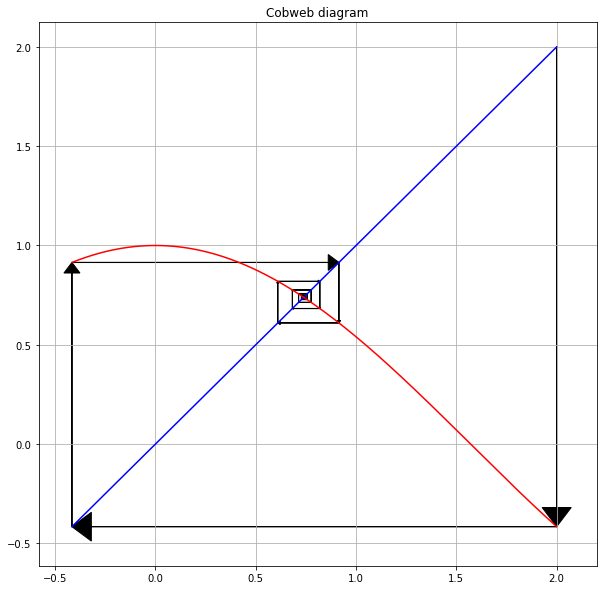

In [9]:
g = lambda x: np.cos(x)
fpi(g, 2, 20, True)

Let's quickly explain the Cobweb Diagram we have here. The <font color="blue">blue</font> line is the function $x$ and the <font color="red">red</font> is the function $g(x)$. The point in which they meet is $g$'s fixed point. In this particular example, we start at <font color="blue">$y = x = 1.5$</font> (the top right corner) and then we "jump" **vertically** to <font color="red">$y = \cos(1.5) \approx 0.07$</font>. After this, we jump **horizontally** to <font color="blue">$x = \cos(1.5) \approx 0.07$</font>. Then, we jump again **vertically** to <font color="red">$y = \cos\left(\cos(1.5)\right) \approx 0.997$</font> and so on. See the pattern here? We're just iterating over $x = \cos(x)$, getting closer to the center of the diagram where the fixed point resides, in $x \approx 0.739$.

It's very important to mention that the algorithm will converge only if the rate of convergence $S < 1$, where $S = \left| g'(r) \right|$. If you want to use this method, you'll have to construct $g(x)$ starting from $f(x)$ accordingly. In this example, $g(x) = \cos(x) \Rightarrow g'(x) = -\sin(x)$ and $|-\sin(0.739)| \approx 0.67$.

### Another example. Look at this web page to undertand the context: https://divisbyzero.com/2008/12/18/sharkovskys-theorem/amp/?__twitter_impression=true

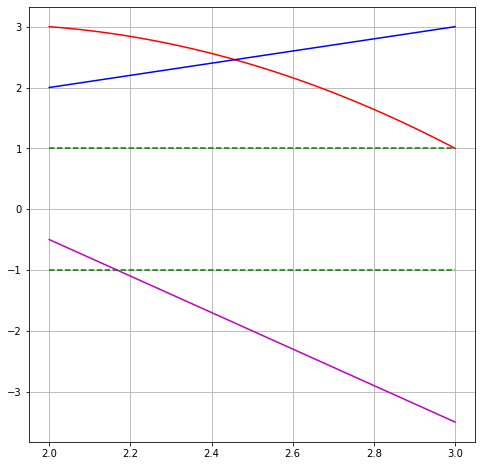

In [10]:
# Consider this funtion
g = lambda x: -(3/2)*x**2+(11/2)*x-2
# Here we compute the derivative of it.
gp = lambda x: -3*x+11/2

# We plot now the funcion itself (red), its derivative (magenta) and the function y=x (blue).
# We also plot the values -1 and 1 with green dashed curves.
# This analyis shows that the fixed point, which is the intersection between teh red and blue curves, 
# does not generate a convergent fix-point-iteration since the derivative (magenta curve) has a value
# lower then -1 about the fized point.
x=np.linspace(2,3,100)
plt.figure(figsize=(8,8))
plt.plot(x,g(x),'r-',label=r'$g(x)$')
plt.plot(x,x,'b-')
plt.plot(x,gp(x),'m-')
plt.plot(x,gp(x)*0+1,'g--')
plt.plot(x,gp(x)*0-1,'g--')
plt.grid(True)
plt.show()

What it is interesting about the previous example is that it generates an interesting limit cicle! In the next cell we evaluate the fixed point with initial guess equal to 1. The iteration oscilates generating the following sequence: 1, 2, 3, 1, 2, 3, .... Which is nice!

 i |     x_i      |    x_{i+1}   ||x_{i+1}-x_i| | e_{i+1}/e_i | e_{i+1}/e_i^2
-----------------------------------------------------------------------------
 0 | 1.0000000000 | 2.0000000000 | 1.0000000000 | 0.0000000000 | 0.0000000000
 1 | 2.0000000000 | 3.0000000000 | 1.0000000000 | 1.0000000000 | 1.0000000000
 2 | 3.0000000000 | 1.0000000000 | 2.0000000000 | 2.0000000000 | 2.0000000000
 3 | 1.0000000000 | 2.0000000000 | 1.0000000000 | 0.5000000000 | 0.2500000000
 4 | 2.0000000000 | 3.0000000000 | 1.0000000000 | 1.0000000000 | 1.0000000000
 5 | 3.0000000000 | 1.0000000000 | 2.0000000000 | 2.0000000000 | 2.0000000000
 6 | 1.0000000000 | 2.0000000000 | 1.0000000000 | 0.5000000000 | 0.2500000000
 7 | 2.0000000000 | 3.0000000000 | 1.0000000000 | 1.0000000000 | 1.0000000000
 8 | 3.0000000000 | 1.0000000000 | 2.0000000000 | 2.0000000000 | 2.0000000000
 9 | 1.0000000000 | 2.0000000000 | 1.0000000000 | 0.5000000000 | 0.2500000000
10 | 2.0000000000 | 3.0000000000 | 1.0000000000 | 1.0000000000 |

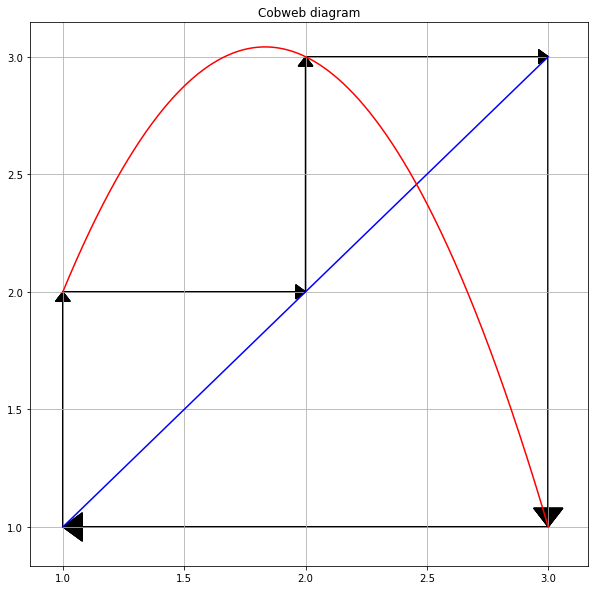

In [11]:
fpi(g, 1, 12, True)

However, we prefer convergent fixed-point-iterations! Here is interesting way to make a non-convergent FPI into a convergent one.

 i |     x_i      |    x_{i+1}   ||x_{i+1}-x_i| | e_{i+1}/e_i | e_{i+1}/e_i^2
-----------------------------------------------------------------------------
 0 | 1.0000000000 | 1.3703703704 | 0.3703703704 | 0.0000000000 | 0.0000000000
 1 | 1.3703703704 | 1.8702941625 | 0.4999237921 | 1.3497942387 | 3.6444444444
 2 | 1.8702941625 | 2.3033768846 | 0.4330827222 | 0.8662974818 | 1.7328590786
 3 | 2.3033768846 | 2.4540725779 | 0.1506956933 | 0.3479605294 | 0.8034504993
 4 | 2.4540725779 | 2.4576349017 | 0.0035623237 | 0.0236391875 | 0.1568670408
 5 | 2.4576349017 | 2.4574138249 | 0.0002210768 | 0.0620597109 | 17.4211316367
 6 | 2.4574138249 | 2.4574279552 | 0.0000141303 | 0.0639159592 | 289.1120393896
 7 | 2.4574279552 | 2.4574270537 | 0.0000009015 | 0.0638009889 | 4515.1789387494
 8 | 2.4574270537 | 2.4574271112 | 0.0000000575 | 0.0638083384 | 70777.8849634007
 9 | 2.4574271112 | 2.4574271075 | 0.0000000037 | 0.0638078755 | 1109218.2194221437
10 | 2.4574271075 | 2.4574271078 | 0.0000000002 

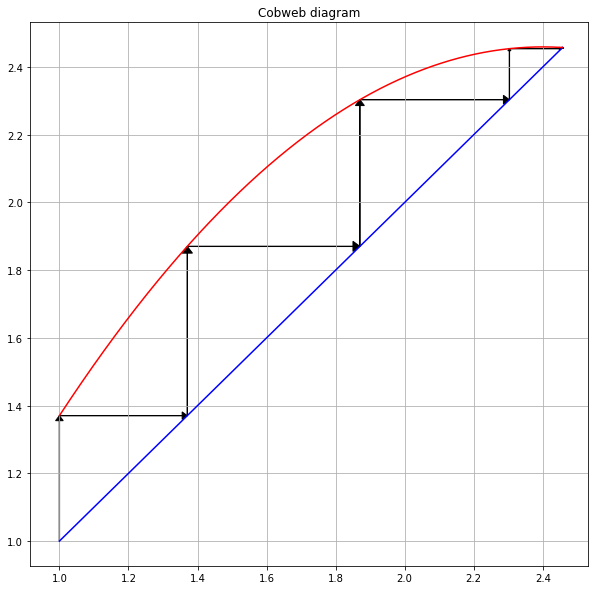

In [12]:
# This is an "avocado" hidden in the code!
a=-1/2.7
g2 = lambda x: x+a*(x-g(x))
fpi(g2, 1, 14, True)

<div id='fpi-textbook-example' />

# FPI - example from textbook
[Back to TOC](#toc)


This example is from the textbook. We are trying to find a root of $f(x)=x^3+x-1$.

 i |     x_i      |    x_{i+1}   ||x_{i+1}-x_i| | e_{i+1}/e_i | e_{i+1}/e_i^2
-----------------------------------------------------------------------------
 0 | 0.7500000000 | 0.6860465116 | 0.0639534884 | 0.0000000000 | 0.0000000000
 1 | 0.6860465116 | 0.6823395826 | 0.0037069290 | 0.0579628903 | 0.9063288301
 2 | 0.6823395826 | 0.6823278039 | 0.0000117787 | 0.0031774687 | 0.8571700804
 3 | 0.6823278039 | 0.6823278038 | 0.0000000001 | 0.0000100600 | 0.8540891497
 4 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 0.0000009369 | 7907.1801642964
 5 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 1.0000000000 | 9007199254740992.0000000000
 6 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 1.0000000000 | 9007199254740992.0000000000
 7 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 1.0000000000 | 9007199254740992.0000000000
 8 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 1.0000000000 | 9007199254740992.0000000000
 9 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 1.0000000000 | 90071992547409

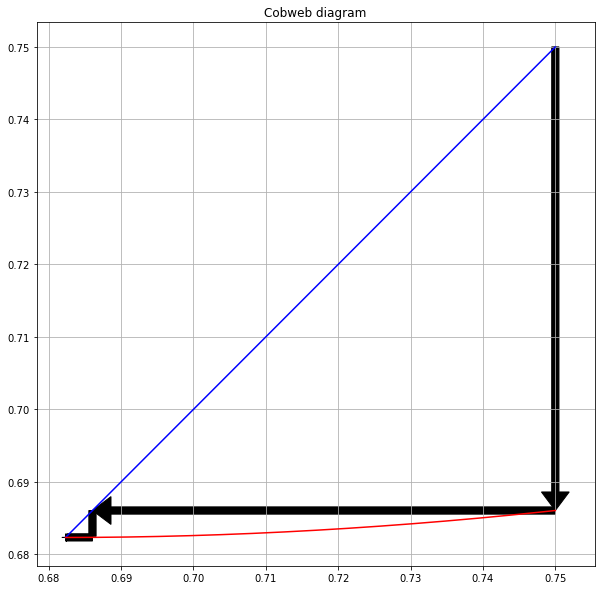

In [13]:
# These are the three functions proposed.
g1 = lambda x: 1-x**3
g2 = lambda x: (1-x)**(1/3)
g3 = lambda x: (1+2*x**3)/(1+3*x**2)
# Change the input function to evaluate different functions.
# Are the three functions convergent fixed point iterations?
fpi(g3, 0.75, 10, True)

 i |     x_i      |    x_{i+1}   ||x_{i+1}-x_i| | e_{i+1}/e_i | e_{i+1}/e_i^2
-----------------------------------------------------------------------------
 0 | 0.7500000000 | 0.6779763150 | 0.0720236850 | 0.0000000000 | 0.0000000000
 1 | 0.6779763150 | 0.6824480491 | 0.0044717341 | 0.0620869943 | 0.8620357907
 2 | 0.6824480491 | 0.6823242405 | 0.0001238086 | 0.0276869349 | 6.1915431709
 3 | 0.6823242405 | 0.6823279092 | 0.0000036687 | 0.0296324135 | 239.3404885671
 4 | 0.6823279092 | 0.6823278007 | 0.0000001085 | 0.0295782485 | 8062.2187013180
 5 | 0.6823278007 | 0.6823278039 | 0.0000000032 | 0.0295798537 | 272587.3459096886
 6 | 0.6823278039 | 0.6823278038 | 0.0000000001 | 0.0295798272 | 9215295.8032791298
 7 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 0.0295799384 | 311541051.4653884768
 8 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 0.0295687236 | 10528180608.3659896851
 9 | 0.6823278038 | 0.6823278038 | 0.0000000000 | 0.0294117647 | 354167948047.3809204102


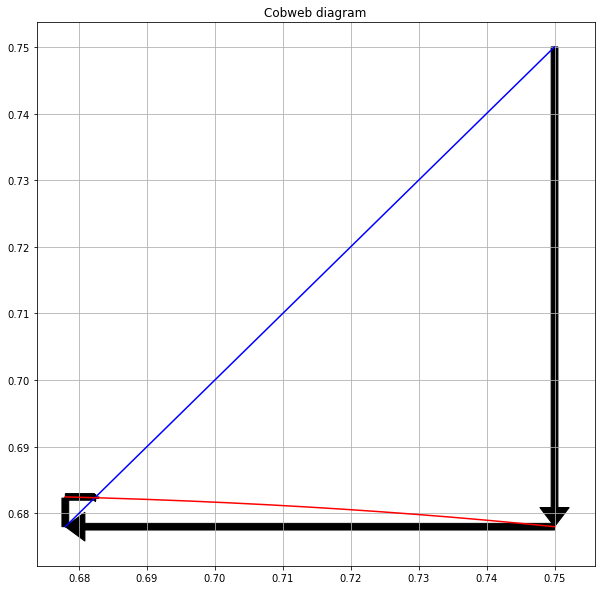

In [14]:
# This is a "hack" to improve the convergence of g2!
a  = -0.6
g4 = lambda x: x+a*(x-g2(x))
fpi(g4, 0.75, 10, True)
# Why does this hack works?

Now that we found the root, let's compute the derivative of each $g(x)$ used previously and understand what exactly was going on.

In [15]:
g1p = lambda x: -3*x**2
g2p = lambda x: -(1/3)*(1-x)**(-2/3)
g3p = lambda x: ((1+3*x**2)*(6*x**2)-(1+2*x**3)*6*x)/((1+3*x**2)**2)
g4p = lambda x: 1+a*(1-g2p(x))
r=0.6823278038280194
print('What is the conclusion then?')
print([g1p(r), g2p(r), g3p(r), g4p(r)])

What is the conclusion then?
[-1.3967136956303043, -0.7159663452349291, 0.0, -0.029579807140957426]


In [16]:
# Or it may be better to apply the absolute value.
print(np.abs([g1p(r), g2p(r), g3p(r), g4p(r)]))

[1.3967137  0.71596635 0.         0.02957981]


<div id='nm' />

# Newton's Method
[Back to TOC](#toc)

The Newton's method also finds a root of a function $f(x)$ but it requires its derivative, i.e. $f'(x)$.
The algorithm is as follows:
\begin{align*}
    x_0 &= \text{initial guess},\\
    x_{i+1} &= x_i - \dfrac{f(x_i)}{f'(x_i)}.
\end{align*}
For roots with multiplicity equal to 1, Newton's method convergens quadratically. However, when the multiplicity is larger that 1, it will show linear convergence. Fortunately, we can modify Newton's method if we know the multiplicity of the root, say $m$, this is as follows:
\begin{align*}
    x_0 &= \text{initial guess},\\
    x_{i+1} &= x_i - m\,\dfrac{f(x_i)}{f'(x_i)}.
\end{align*}
This modified version will also show quadratic convergence!

In [17]:
def newton_method(f, fp, x0, rel_error=1e-8, m=1, maxNumberIterations=100):
    #Initialization of hybrid error and absolute
    hybrid_error = 100
    error_i = np.inf
    
    print('i |     x_i      |     x_{i+1}  |     |x_{i+1}-x_i|      |  e_{i+1}/e_i | e_{i+1}/e_i^2')
    print('----------------------------------------------------------------------------------------')
    
    #Iteration counter
    i = 1
    while (hybrid_error > rel_error and hybrid_error < 1e12 and i<=maxNumberIterations):
        #Newton's iteration
        x1 = x0-m*f(x0)/fp(x0)
        
        #Checking if root was found
        if f(x1) == 0.0:
            hybrid_error = 0.0
            break
        
        #Computation of hybrid error
        hybrid_error = abs(x1-x0)/np.max([abs(x1),1e-12])
        
        #Computation of absolute error
        error_iminus1 = error_i
        error_i = abs(x1-x0)
        
        #Increasing counter
        i += 1
        
        #Showing some info
        print("%d | %.10f | %.10f | %.20f | %.10f | %.10f" % 
              (i, x0, x1, error_i, error_i/error_iminus1, error_i/(error_iminus1**2)))
        #Updating solution
        x0 = x1
    
    #Checking if solution was obtained
    if hybrid_error < rel_error: 
        return x1
    elif i>=maxNumberIterations:
        print('Newton''s Method did not converged. Too many iterations!!')
        return None
    else:
        print('Newton''s Method did not converged!')
        return None

First example, let's compute a root of $\sin(x)$, near $x_0=3.1$.

In [18]:
# Example funtion
f = lambda x: np.sin(x)
# The derivative of f
fp = lambda x: np.cos(x)
newton_method(f, fp, 3.1,rel_error=1e-15)

i |     x_i      |     x_{i+1}  |     |x_{i+1}-x_i|      |  e_{i+1}/e_i | e_{i+1}/e_i^2
----------------------------------------------------------------------------------------
2 | 3.1000000000 | 3.1416166546 | 0.04161665458563579278 | 0.0000000000 | 0.0000000000
3 | 3.1416166546 | 3.1415926536 | 0.00002400099584720650 | 0.0005767161 | 0.0138578204
4 | 3.1415926536 | 3.1415926536 | 0.00000000000000444089 | 0.0000000002 | 0.0000077092
5 | 3.1415926536 | 3.1415926536 | 0.00000000000000000000 | 0.0000000000 | 0.0000000000


Now, we will look at the example when Newton's method shows linear convergence.

In [19]:
f = lambda x: x**2
fp = lambda x: 2*x # the derivative of f
newton_method(f, fp, 3.1, rel_error=1e-1, m=3, maxNumberIterations=10)

i |     x_i      |     x_{i+1}  |     |x_{i+1}-x_i|      |  e_{i+1}/e_i | e_{i+1}/e_i^2
----------------------------------------------------------------------------------------
2 | 3.1000000000 | -1.5500000000 | 4.65000000000000035527 | 0.0000000000 | 0.0000000000
3 | -1.5500000000 | 0.7750000000 | 2.32500000000000017764 | 0.5000000000 | 0.1075268817
4 | 0.7750000000 | -0.3875000000 | 1.16249999999999986677 | 0.5000000000 | 0.2150537634
5 | -0.3875000000 | 0.1937500000 | 0.58124999999999993339 | 0.5000000000 | 0.4301075269
6 | 0.1937500000 | -0.0968750000 | 0.29062499999999996669 | 0.5000000000 | 0.8602150538
7 | -0.0968750000 | 0.0484375000 | 0.14531249999999998335 | 0.5000000000 | 1.7204301075
8 | 0.0484375000 | -0.0242187500 | 0.07265624999999999167 | 0.5000000000 | 3.4408602151
9 | -0.0242187500 | 0.0121093750 | 0.03632812499999999584 | 0.5000000000 | 6.8817204301
10 | 0.0121093750 | -0.0060546875 | 0.01816406249999999792 | 0.5000000000 | 13.7634408602
11 | -0.0060546875 | 0.003027

e_{i+1}/e_i=S=(m-1)/m -> e_{i+1}/e_i=(m-1)/m -> 0.5=(m-1)/m -> m=2

In [20]:
newton_method(f, fp, 3.1, rel_error=1e-1, m=2, maxNumberIterations=10)

i |     x_i      |     x_{i+1}  |     |x_{i+1}-x_i|      |  e_{i+1}/e_i | e_{i+1}/e_i^2
----------------------------------------------------------------------------------------


<div id='wilkinson' />

# Wilkinson Polynomial
[Back to TOC](#toc)

https://en.wikipedia.org/wiki/Wilkinson%27s_polynomial

**Final question: Why is the root far far away from $16$?**

In [21]:
x = sym.symbols('x', reals=True)
W=1
for i in np.arange(1,21):
        W*=(x-i)
W # Printing W nicely

In [22]:
# Expanding the Wilkinson polynomial
We=sym.expand(W)
We 

In [23]:
# Just computiong the derivative
Wep=sym.diff(We,x)
Wep

In [24]:
# Lamdifying the polynomial to be used with sympy
P=sym.lambdify(x,We)
Pp=sym.lambdify(x,Wep)

In [25]:
# Using scipy function to compute a root
root = optimize.newton(P,16)
print(root)

RuntimeError: Failed to converge after 50 iterations, value is 16.013917983178537.

In [26]:
newton_method(P, Pp, 16.01, rel_error=1e-10, maxNumberIterations=10)

i |     x_i      |     x_{i+1}  |     |x_{i+1}-x_i|      |  e_{i+1}/e_i | e_{i+1}/e_i^2
----------------------------------------------------------------------------------------
2 | 16.0100000000 | 16.0425006915 | 0.03250069153185108917 | 0.0000000000 | 0.0000000000
3 | 16.0425006915 | 16.0050204647 | 0.03748022678450269041 | 1.1532132093 | 35.4827283637
4 | 16.0050204647 | 16.0078597186 | 0.00283925384213290499 | 0.0757533795 | 2.0211558458
5 | 16.0078597186 | 15.9851271041 | 0.02273261449981944793 | 8.0065452981 | 2819.9469801818
6 | 15.9851271041 | 16.0029892675 | 0.01786216337692181355 | 0.7857505074 | 34.5648982597
7 | 16.0029892675 | 16.0136315293 | 0.01064226179553884322 | 0.5957991522 | 33.3553746866
8 | 16.0136315293 | 16.0001980846 | 0.01343344470737761753 | 1.2622734683 | 118.6095110764
9 | 16.0001980846 | 16.0178167527 | 0.01761866814365831146 | 1.3115525115 | 97.6333725295
10 | 16.0178167527 | 16.0287977529 | 0.01098100018750258755 | 0.6232593802 | 35.3749429376
11 | 16.028

<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)

* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistants: Laura Bermeo, Alvaro Salinas, Axel Simonsen and Martín Villanueva. DI UTFSM. March 2016._ v1.1.
* _Update April 2020 - v1.32 - C.Torres_ : Re-ordering the notebook.
* _Update April 2021 - v1.33 - C.Torres_ : Updating format and re-re-ordering the notebook. Adding 'maxNumberIterations' to bisection, fpi and Newton's method. Adding more explanations.
* _Update April 2021 - v1.33 - C.Torres_ : Updating description and solution of 'Proposed classwork'.

<div id='extraexamples' />

# Extra examples
[Back to TOC](#toc)

## Propose Classwork
1. Build a FPI such that given $a$ computes $\displaystyle \frac{1}{a}$. The constraint is that you can't use a division in the 'final' FPI. Write down your solution below or go and see the [solution](#sol1). 

_Hint: I strongly suggest to use Newton's method._

In [27]:
print('Please try to solve it before you see the solution!!!')

Please try to solve it before you see the solution!!!


2. Build an algorithm that computes $\log(x_i)$ for $x_i=0.1*i+0.5$, for $i\in{0,1,2,\dots,10}$. The only special function available is $\exp(x)$, in particular use _np.exp(x)_. You can also use $*$, $÷$, $+$, and $-$. It would be nice to use the result from previous example to replace $÷$.

# In class

Which function shows quadratic convergence? Why?

 i |     x_i      |    x_{i+1}   ||x_{i+1}-x_i| | e_{i+1}/e_i | e_{i+1}/e_i^2
-----------------------------------------------------------------------------
 0 | 3.0000000000 | 2.7333333333 | 0.2666666667 | 0.0000000000 | 0.0000000000
 1 | 2.7333333333 | 2.5525203252 | 0.1808130081 | 0.6780487805 | 2.5426829268
 2 | 2.5525203252 | 2.4337859123 | 0.1187344129 | 0.6566696394 | 3.6317610455
 3 | 2.4337859123 | 2.3579112134 | 0.0758746990 | 0.6390287123 | 5.3820008621
 4 | 2.3579112134 | 2.3104331500 | 0.0474780634 | 0.6257430215 | 8.2470577167
 5 | 2.3104331500 | 2.2811657946 | 0.0292673554 | 0.6164395368 | 12.9836706220
 6 | 2.2811657946 | 2.2633049812 | 0.0178608134 | 0.6102639994 | 20.8513543865
 7 | 2.2633049812 | 2.2524757347 | 0.0108292465 | 0.6063131795 | 33.9465604055
 8 | 2.2524757347 | 2.2459365357 | 0.0065391990 | 0.6038461667 | 55.7606814775
 9 | 2.2459365357 | 2.2419977848 | 0.0039387509 | 0.6023292551 | 92.1105557855


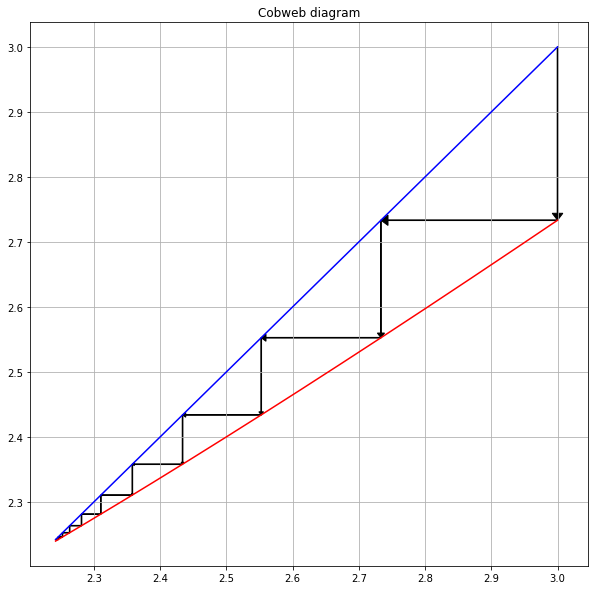

In [28]:
g1 = lambda x: (4./5.)*x+1./x
g2 = lambda x: x/2.+5./(2*x)
g3 = lambda x: (x+5.)/(x+1)
fpi(g1, 3.0, 10, True)

### Building a FPI to compute the cubic root of 7

In [29]:
# What is 'a'? Can we find another 'a'?
a = -3*(1.7**2)
print(a)

-8.669999999999998


 i |     x_i      |    x_{i+1}   ||x_{i+1}-x_i| | e_{i+1}/e_i | e_{i+1}/e_i^2
-----------------------------------------------------------------------------
 0 | 1.7000000000 | 1.9407151096 | 0.2407151096 | 0.0000000000 | 0.0000000000
 1 | 1.9407151096 | 1.9050217836 | 0.0356933259 | 0.1482803717 | 0.6159994359
 2 | 1.9050217836 | 1.9149952799 | 0.0099734962 | 0.2794218792 | 7.8284069055
 3 | 1.9149952799 | 1.9123789078 | 0.0026163720 | 0.2623324846 | 26.3029612960
 4 | 1.9123789078 | 1.9130779941 | 0.0006990863 | 0.2671968386 | 102.1249403998
 5 | 1.9130779941 | 1.9128920879 | 0.0001859062 | 0.2659273937 | 380.3927776292
 6 | 1.9128920879 | 1.9129415886 | 0.0000495007 | 0.2662670485 | 1432.2655048556
 7 | 1.9129415886 | 1.9129284127 | 0.0000131759 | 0.2661767579 | 5377.2324999715
 8 | 1.9129284127 | 1.9129319201 | 0.0000035074 | 0.2662008017 | 20203.5604717720
 9 | 1.9129319201 | 1.9129309865 | 0.0000009337 | 0.2661944019 | 75894.1168915227
10 | 1.9129309865 | 1.9129312350 | 0.00000024

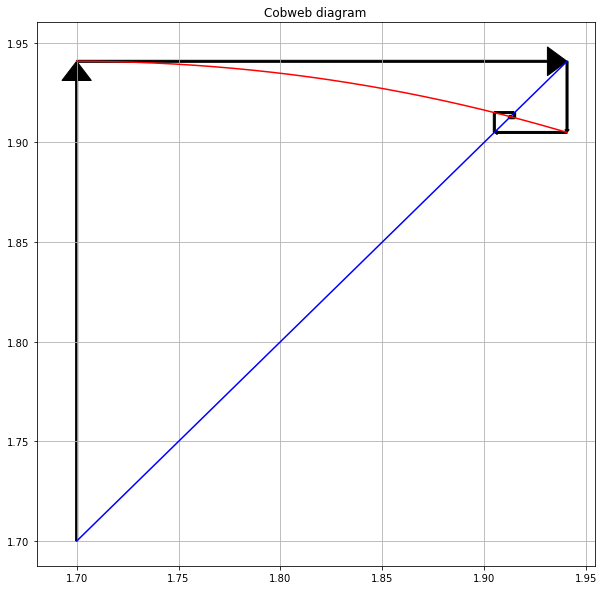

-1.0819690920982339e-08


In [30]:
f = lambda x: x**3-7
g =  lambda x: f(x)/a+x
r=fpi(g, 1.7, 14, True)
print(f(r))

### Playing with some roots

The following example proposed a particular function $f(x)$. 
The idea here is first obtain an initial guess for applying the Newton's method from the plot in semilogy scale.
The plot of $f(x)$ (blue) shows that there seems to be 2 roots in the interval plotted.
Now, the plot of $f'(x)$ (magenta) indicates that the derivative may also have a 0 together with a root, this means that the multiplicity of that root may be higher than 1. How can we find out that? 

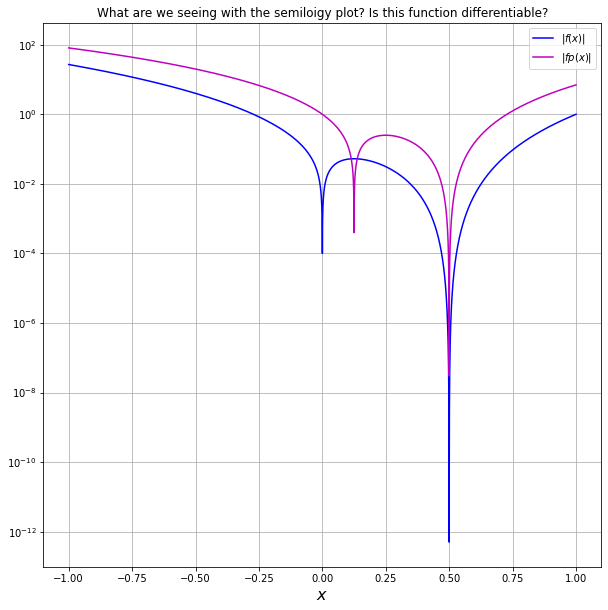

In [31]:
f = lambda x: 8*x**4-12*x**3+6*x**2-x
fp = lambda x: 32*x**3-36*x**2+12*x-1

x = np.linspace(-1,1,10000)
plt.figure(figsize=(10,10))

plt.title('What are we seeing with the semiloigy plot? Is this function differentiable?')
plt.semilogy(x,np.abs(f(x)),'b-',label=r'$|f(x)|$')
plt.semilogy(x,np.abs(fp(x)),'m-',label=r'$|fp(x)|$')
plt.grid()
plt.legend()
plt.xlabel(r'$x$',fontsize=16)
plt.show()

In [32]:
r=newton_method(f, fp, 0.4, rel_error=1e-8, m=1)
print([r,f(r)])
# Is this showing quadratic convergence? If not, can you fix it?

i |     x_i      |     x_{i+1}  |     |x_{i+1}-x_i|      |  e_{i+1}/e_i | e_{i+1}/e_i^2
----------------------------------------------------------------------------------------
2 | 0.4000000000 | 0.4363636364 | 0.03636363636363626473 | 0.0000000000 | 0.0000000000
3 | 0.4363636364 | 0.4586595886 | 0.02229595222295999157 | 0.6131386861 | 16.8613138686
4 | 0.4586595886 | 0.4728665654 | 0.01420697676575599644 | 0.6371998210 | 28.5791705436
5 | 0.4728665654 | 0.4820874099 | 0.00922084451765831092 | 0.6490363622 | 45.6843403691
6 | 0.4820874099 | 0.4881331524 | 0.00604574254164202962 | 0.6556603932 | 71.1063278311
7 | 0.4881331524 | 0.4921210847 | 0.00398793230801725018 | 0.6596265522 | 109.1059613639
8 | 0.4921210847 | 0.4947614808 | 0.00264039610890853815 | 0.6620965214 | 166.0250150478
9 | 0.4947614808 | 0.4965138385 | 0.00175235769376258510 | 0.6636722755 | 251.3533000745
10 | 0.4965138385 | 0.4976786184 | 0.00116477990795793573 | 0.6646930088 | 379.3135449254
11 | 0.4976786184 | 0.49845

<div id='sol1' />

## Solutions
Problem: Build a FPI such that given $a$ computes $\displaystyle \frac{1}{a}$

In [33]:
# We are finding the 1/a
# Solution code:
a = 2.1
g = lambda x: 2*x-a*x**2
gp = lambda x: 2-2*a*x
r=fpi(g, 0.7, 7, flag_cobweb=False)
print('Reciprocal found :',r)
print('Reciprocal computed explicitly: ', 1/a)
# Are we seeing quadratic convergence?

 i |     x_i      |    x_{i+1}   ||x_{i+1}-x_i| | e_{i+1}/e_i | e_{i+1}/e_i^2
-----------------------------------------------------------------------------
 0 | 0.7000000000 | 0.3710000000 | 0.3290000000 | 0.0000000000 | 0.0000000000
 1 | 0.3710000000 | 0.4529539000 | 0.0819539000 | 0.2491000000 | 0.7571428571
 2 | 0.4529539000 | 0.4750566054 | 0.0221027054 | 0.2696968100 | 3.2908355795
 3 | 0.4750566054 | 0.4761877763 | 0.0011311709 | 0.0511779387 | 2.3154603813
 4 | 0.4761877763 | 0.4761904762 | 0.0000026999 | 0.0023867984 | 2.1100246103
 5 | 0.4761904762 | 0.4761904762 | 0.0000000000 | 0.0000056698 | 2.1000206476
 6 | 0.4761904762 | 0.4761904762 | 0.0000000000 | 0.0000000000 | 0.0000000000
Reciprocal found : 0.47619047619047616
Reciprocal computed explicitly:  0.47619047619047616


### What is this plot telling us?

This plots shows that, even if we don't know the exact value of $g'(r)$, we can determine if the FPI will convergan by looking at the plot.
In this plot we observe that when plotting $g'(x)$ (magenta), we can determine that the value of $|g'(r)|$ will be less than 1 since it is between the black lines, that are located at $y=-1$ and $y=1$.

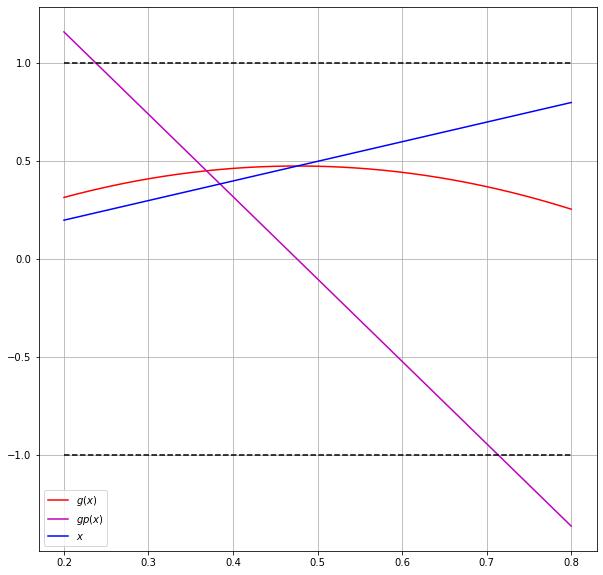

In [34]:
xx=np.linspace(0.2,0.8,1000)
plt.figure(figsize=(10,10))
plt.plot(xx,g(xx),'r-',label=r'$g(x)$')
plt.plot(xx,gp(xx),'m-',label=r'$gp(x)$')
plt.plot(xx,xx,'b-',label=r'$x$')
plt.plot(xx,0*xx+1,'k--')
plt.plot(xx,0*xx-1,'k--')
plt.legend(loc='best')
plt.grid()
plt.show()